In [280]:
import os
import sys
import glob
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xray
import random
import itertools
import urllib
import json
import importlib as imp

from IPython import display

sys.path.append('/nuwa_cluster/home/jackyu/climatools/')
import climatools.dates as climadates
import climatools.viz as climaviz
import climatools.misc as climamisc
import climatools.muths as climaths
import climatools.units as climaunits
import climatools.geocoords as climageocoords
import climatools.prepdatasets as climaprepdata

sys.path.append('/nuwa_cluster/home/jackyu/radiation/rtmtools/')
import rtmtools.rrtmg.sw.info as rrtmgswinfo

#from IPython.lib.deepreload import reload as dreload
imp.reload(climadates)
imp.reload(climaviz)
imp.reload(climamisc)
imp.reload(climaths)
imp.reload(climaunits)
imp.reload(climaprepdata)

imp.reload(rrtmgswinfo)


matplotlib.rcParams.update({'font.size': 13, 
                            'xtick.direction': 'out',
                            'ytick.direction': 'out'})

# ARM95

2 cases considered here are:

* a McICA --- RRTMG with McICA cloud overlapping, output sent to CAM
* b MaxRand --- RRTMG with CLIRAD's maximum random cloud overlapping

Both above cases use the same input state in each model nstep. 

In [2]:

iopname = 'arm95_LW_rrtmgMcICA_rrtmgMaxRand_SW_rrtmgMcICA_rrtmgMaxRand'

def case_names():
    'Give the different cases names'
    return ['a McICA', 'b MaxRand']



def get_cases_difference():
    '''
    define the differences between cases to compute
    '''
    return [('b MaxRand', 'a McICA'),]



def get_cases():
    '''
    Returns a dictionary where the keys are cases, such
    as a name for a SCAM run, and the values are the datasets (xray)
    for the cases
    '''
    ds = xray.open_dataset('../examples/ARM95/cam5_noavg_LW_rrtmgMcICA_rrtmgMaxRand_SW_rrtmgMcICA_rrtmgMaxRand/camrun.cam.h0.0095-07-18-19800.nc',
                          decode_times = False)
    RTM1_names = [k for k in list(ds) if '_RTM1' in k]
    rrtmg_names = [name.split('_')[0] for name in RTM1_names]
    common_names = [k for k in list(ds) 
                    if k not in (RTM1_names + rrtmg_names)]
    
    ds_RTM1 = xray.Dataset()
    ds_RTM1.update(ds[common_names].copy(deep = True), inplace = True)
    ds_RTM1.update(ds[RTM1_names].copy(deep = True), inplace = True)
    ds_RTM1.rename(dict(zip(RTM1_names, rrtmg_names)), inplace = True)
    
    ds_rrtmg = xray.Dataset()
    ds_rrtmg.update(ds[common_names].copy(deep = True), inplace = True)
    ds_rrtmg.update(ds[rrtmg_names].copy(deep = True), inplace = True)     
    
       
    return dict(zip(case_names(), [ds_rrtmg, ds_RTM1]))



def compute_net_solar_fluxes(datasets):
    '''
    Compute net solar fluxes
    '''
    for casename, ds in datasets.items():
        ds['net_FS'] = ds['FDS'] - ds['FUS']
        ds['net_FS'].attrs['units'] = ds['FDS'].attrs['units']
        ds['net_FS'].attrs['long_name'] = 'net solar flux'
        ds['net_FS'].attrs['case_name'] = casename
        
        ds['net_FSC'] = ds['FDSC'] - ds['FUSC']
        ds['net_FSC'].attrs['units'] = ds['FDSC'].attrs['units']
        ds['net_FSC'].attrs['long_name'] = 'net solar flux (clear-sky)'
        ds['net_FSC'].attrs['case_name'] = casename
    return datasets




def linestyles_by_case():
    '''
    Assign lineplot properties to the cases
    '''
    return dict(zip(case_names(), 
                    [{'colour': 'g', 'linestyle': '--'},
                     {'colour': 'b', 'linestyle': '--'}]))



def get_d3interests():
    '''
    List here all variables of interest that have dimensions (time, lev, lon, lat)
    '''
    d3interests = ['CLOUD', 'QRL', 'QRS', 'Q',
                   'CLDICE', 'CLDLIQ', 
                   'AQSNOW', 'AREI', 'AREL',
                   'AWNC', 'AWNI', 
                   'DCQ', 'DTCOND', 
                   'ICIMR', 'ICWMR', 
                   'NUMLIQ', 'NUMICE', 'T', 'RELHUM',
                   'FUL', 'FDL', 'FULC', 'FDLC', 'net_FS', 'net_FSC',
                   'FUS', 'FDS', 'FUSC', 'FDSC',
                   'TOT_CLD_VISTAU']
    return sorted(d3interests)




def get_d2interests():
    '''
    List here all variables of interest that have dimensions (time, lon, lat)
    '''
    interests = ['FSNT', 'FSNS', 'FLNT', 'FLNS',
                 'CLDLOW', 'CLDMED', 'CLDHGH', 'CLDTOT',
                 'TS', 'TREFHT', 'TROP_T', 'TROP_Z', 'TMQ', 'TGCLDIWP', 'TGCLDLWP', 
                 'PRECT', 'PRECL', 'PRECC',
                 'LHFLX', 'SHFLX',
                'SOLIN']
    return interests






def convert_units(datasets):
    '''
    Convert units for certain fields for all cases in DATASETS.
    INPUT:
    ilev --- level(interface) pressure in mbar
    lev  --- layer(level) pressure in mbar
    datetimes --- time in pandas DatetimeIndex objects
    '''
    for name, ds in datasets.items():
        
        for k in ['TOT_CLD_VISTAU',]:
            if k in ds:
                pass #ds[k].values[ds[k].isnull().values] = - 0.
        
        for k in ['FUS', 'FDS', 'net_FS', 'net_FSC']:
            if k in ds:
                ds[k] *= 1e3
    
        for k in ['QRL', 'QRS', 'DTCOND']:
            if k in ds:
                ds[k] *= 86400
                ds[k].attrs['units'] = 'K/day'
        
        for k in ['Q', ]:
            if k in ds:
                ds[k] *= 1e3
                ds[k].attrs['units'] = 'g/kg'
        
        for k in ['CLDICE', 'CLDLIQ', 'AQSNOW']:
            if k in ds:
                ds[k] *= 1e6
                ds[k].attrs['units'] = 'mg/kg'
                
        for k in ['PRECC', 'PRECL', 'PRECT']:
            if k in ds:
                ds[k] *= 1e3 * 86400
                ds[k].attrs['units'] = 'mm/day'
                
    return datasets

In [3]:
def prep_data(cases):
    '''
    Preprocess data for plotting. 
    pressure and datetimes need to be provided for unit conversion.
    INPUT:
    ilev --- level(interface) pressure [mbar]
    lev --- layer(level) pressure [mbar]
    datetimes --- time in pandas DatetimeIndex objects    
    '''
    interests = get_d3interests() + get_d2interests()
    cases = climaprepdata.convert_pressure_time_units(cases)
    cases = climaprepdata.gather_interests_from_cases(cases, interests)
    cases = convert_units(cases)
    diff_cases = climaprepdata.take_difference_between_cases(cases, get_cases_difference())
    cases, diff_cases = climaprepdata.passon_attrs_casename(cases, diff_cases, interests = interests)
    return cases, diff_cases


In [14]:
################## Variables of dimensions (time, lev, lon, lat) ########################
#########################################################################################


# for writing plotted figures to disk
def writefig_contourfs(d3sets, diff_d3sets, interests, 
                       dir_label = 'example_dir_label', file_label = 'example_file_label',
                       fmt = 'png'):
    '''
    For each interest, produce one figure containing contour
    plots for all cases, another figure containing contour 
    Hackish colormap selection here, basically look up a dictionary.
    '''

    for interest in interests:
        
        dirname = 'figs_{}'.format(dir_label)
        if dirname not in glob.glob(dirname):
            os.mkdir(dirname)

            
        filename = '_'.join([interest, file_label]) if file_label else interest
            
        fig = climaviz.contourf_interest_for_all_cases(d3sets, interest,
                                           cmap = 'auto-select')
        fig.savefig(dirname + '/contourf_{}.{}'.format(filename, fmt))
        plt.close()
        
        fig = climaviz.contourf_interest_for_all_cases(diff_d3sets, interest,
                                           cmap = 'auto-select')
        fig.savefig(dirname + '/contourf_{}_diff.{}'.format(filename, fmt))
        plt.close()
        

        
def writefig_timeaveraged_VSplots(d3sets, diff_d3sets, interests, 
                                 dir_label = 'example_dir_label', file_label = 'example_file_label',
                                 fmt = 'png'):
    '''
    Average over the time dimension, plot against pressure.
    Save figure.
    '''
    for interest in interests:        
        dirname = 'figs_{}'.format(dir_label)
        if dirname not in glob.glob(dirname):
            os.mkdir(dirname)
               
        filename = '_'.join([interest, file_label]) if file_label else interest
        
        fig = climaviz.plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, 
                               interest = interest, xscale = 'linear',
                               bot_xlabels_rotate = 10., 
                               top_xlabels_rotate = 20.,
                               linestyles = linestyles_by_case())
        fig.savefig(dirname + '/plot_{}_timeaverage.{}'.format(filename, fmt))
        plt.close()
        
        
        
        
def write_d3variable_html_page(interest = 'CLOUD', 
                               dir_label = 'example_dir_label', file_label = 'example_file_label'):
    '''
    Write and save an HTML for interest.  
    Include figures produced for interest: contourfs and time-averaged line plots for example.
    HTML file named by interest and file_label, saved in a directory named by dir_label.
    '''
    figdir = 'figs_' + dir_label
    filename = '_'.join([interest, file_label]) if file_label else interest
    with open(os.path.join(figdir, 'page_{}.html'.format(filename)), 
              mode = 'w', encoding = 'utf-8') as f:
        f.write('''
                <img src="contourf_{suffix}.png" height="450">
                <img src="contourf_{suffix}_diff.png" height="450">
                <br>
                <img src="plot_{suffix}_timeaverage.png" height="500">
        '''.format(figdir = figdir, suffix = filename))

        
        
        
def write_d3variable_links_html(d3sets, interests = ['T'],
                               dir_label = 'example_dir_label', file_label = 'example_file_label'):
    '''
    Write HTML of hyperlinks to HTML files containing figures.
    A hyperlink is written for each interest. 
    '''
    hyperlinks = ['<a href="figs_{dir_label}/page_{filename}.html">{interest}: {longname}</a>'\
                 .format(dir_label = dir_label, 
                         file_label = file_label, 
                         interest = interest, 
                         filename = '_'.join([interest, file_label]) if file_label else interest,
                         longname = d3sets[random.choice(list(d3sets.keys()))][interest].attrs['long_name']) \
                 for interest in interests]
    return '<br>'.join(hyperlinks)
    

In [5]:
############### Variables of dimensions (lon, lat, time) ##########################
###################################################################################


def writefig_plotVS_timeseries(dsets, diff_dsets, interests,
                               dir_label = 'example_dir_label',
                               file_label = 'example_file_label',
                               fmt = 'png'):
    '''
    Plot and save figures of time-series of variables of interest
    '''
    for interest in interests:
        fig = climaviz.plotVS_interest_for_all_cases(dsets, diff_dsets, interest = interest,
                                                    linestyles = linestyles_by_case())
        
        dirname = 'figs_{}'.format(dir_label)
        
        if dirname not in glob.glob(dirname):
            os.mkdir(dirname)
            
        filename = '_'.join([interest, file_label]) if file_label else interest
            
        fig.savefig(dirname + '/plotVSts_{}.{}'.format(filename, fmt))
        plt.close()


        
        
def write_d2variable_html_page(interest = 'FLNS',
                               dir_label = 'example_dir_label', 
                               file_label = 'example_file_label'):
    '''
    Write and save an HTML for interest.  
    Include figures produced for interest: contourfs and time-averaged line plots for example.
    HTML file named by interest and file_label, saved in a directory named by dir_label.   
    '''
    figdir = 'figs_{}'.format(dir_label)
    filename = '_'.join([interest, file_label]) if file_label else interest
    with open(os.path.join(figdir, 'page_{}.html'\
                           .format(filename)),
             mode = 'w', encoding = 'utf-8') as f:
        f.write('''
        <img src="plotVSts_{}.png" width=700>
        '''.format(filename))
        
        
        

def write_d2variables_html(d2sets, interests = ['FLNS'],
                          dir_label = 'example_dir_label',
                          file_label = 'example_file_label'):
    hyperlinks = ['<a href="figs_{dir_label}/page_{filename}.html">{interest}: {longname}</a>'\
                 .format(dir_label = dir_label, 
                         interest = interest,
                         filename = '_'.join([interest, file_label]) if file_label else interest,
                         longname = d2sets[random.choice(list(d2sets.keys()))]\
                         [interest].attrs['long_name'])\
                 for interest in interests]
    return '<br>'.join(hyperlinks)


In [6]:
cases = get_cases()
cases = compute_net_solar_fluxes(cases)
dsets, diff_dsets = prep_data(cases) 

# Variables of dimensions (time, ilev, lon, lat)

In [15]:
# plot (time, lev/ilev, lon, lat) variables, write figures to disk 

writefig_contourfs(dsets, diff_dsets, get_d3interests(), 
                   dir_label = iopname, file_label = '',
                  fmt = 'png')

writefig_timeaveraged_VSplots(dsets, diff_dsets, get_d3interests(), 
                              dir_label = iopname, file_label = '',
                              fmt = 'png')

In [16]:
# create HTML files and generate HTML page for each interest
for interest in get_d3interests():
    write_d3variable_html_page(interest = interest, dir_label = iopname, file_label = '')


display.HTML(write_d3variable_links_html(dsets, interests = get_d3interests(), dir_label = iopname, file_label = ''))

# Variables of dimensions (lon, lat, time)

In [9]:
# plot (time, lon, lat) variables, and write figures to disk and create HTML files
writefig_plotVS_timeseries(dsets, diff_dsets, get_d2interests(),
                           dir_label = iopname, file_label = '',
                           fmt = 'png')  

In [10]:
# generate HTML page for each interest
for interest in get_d2interests():
    write_d2variable_html_page(interest = interest, dir_label = iopname, file_label = '')



display.HTML(write_d2variables_html(dsets, interests = get_d2interests(),
                                   dir_label = iopname, file_label = ''))

In [11]:
def slice_in_time(cases, time = slice(None)):
    return {casename: ds.sel(time = time) for casename, ds in cases.items()}

In [282]:
which_timeslice = slice('1995-07-19 05:00:00', '1995-07-25 05:00:00')

d3sets_subtime = slice_in_time(d3sets, time = which_timeslice)
diff_d3sets_subtime = slice_in_time(diff_d3sets, time = which_timeslice)

In [283]:
# plot and write figures to disk
#interests = get_d3interests()

#writefig_contourfs(d3sets_subtime, diff_d3sets_subtime, interests, 
#                   dir_label = iopname, file_label = which_timeslice,
#                  fmt = 'png')

#writefig_timeaveraged_VSplots(d3sets_subtime, diff_d3sets_subtime, interests, 
#                              dir_label = iopname, file_label = which_timeslice,
#                              fmt = 'png')


In [284]:
# generate HTML page for each interest
#for interest in get_d3interests():
#    write_d3variable_html_page(interest = interest, dir_label = iopname, file_label = which_timeslice)


#display.HTML((write_d3variable_links_html(interests = interests, dir_label = iopname, file_label = which_timeslice)))

# Scaled cloud optical depth from cldscale()

In [317]:
def tauc_datfilepaths():
    return {'shortwave': '../examples/ARM95/cam5_noavg_LW_rrtmgMcICA_rrtmgMaxRand_SW_rrtmgMcICA_rrtmgMaxRand/tauc_clirad_scaled_beam.dat'}


def tauc_variable_names():
    return {'shortwave': 'tauc_sw',}


def tauc_dimension_names():
    return {'shortwave': 'nbndsw',}



def rrtmg_wband_limits():
    return {'shortwave': rrtmgswinfo.wavenumber_bands()}



def update_dsets_with_tauc(dsets, spectral_region = 'shortwave'):
    
    case_name = 'b MaxRand'
    
    df = pd.read_csv(tauc_datfilepaths()[spectral_region], sep = r'\s+')
    ds = df.set_index(['nstep', 'ilay', 'ibnd']).drop('icol', axis = 1).stack()
    ds.index = ds.index.droplevel(3)

    df = ds.unstack(0)
    df = df.reindex(columns = range(1, 1226 + 1), )
    ds = df.stack()
    
    da = xray.DataArray.from_series(ds)
    da.attrs['case_name'] = case_name
    da.attrs['long_name'] = '{} scaled cloud optical depth'.format(spectral_region)
    da.attrs['units'] = '1'
    
    tauc_var_name = tauc_variable_names()[spectral_region]
    tauc_dim_name = tauc_dimension_names()[spectral_region]
    
    dsets[case_name].coords[tauc_dim_name] = (tauc_dim_name, 
                                                 range(1, len(da.coords['ibnd']) + 1))
    dsets[case_name][tauc_var_name] = (('lev', tauc_dim_name, 'time'), 
                                          da, da.attrs)
    return
 
    

def plot_tauc(ax, dsets, spectral_region = 'shortwave', wbandn = 1):
    case_name = 'b MaxRand'
    
    tauc_var_name = tauc_variable_names()[spectral_region]
    tauc_dim_name = tauc_dimension_names()[spectral_region]
    
    wband_limits = rrtmg_wband_limits()[spectral_region][wbandn]
    wband_limits_nm = [map(climaunits.wavenumber_to_nanometres, limits) for limits in wband_limits]
        
    
    da = dsets[case_name][tauc_var_name].loc[{tauc_dim_name: wbandn}]
    
    cmap_limits = climaviz.get_cmap_limits(da, quantile = 1.)
    cmap_levels = climaviz.get_nicenround_steps(cmap_limits)
    

    
    ax = climaviz.contourf_DataArray(ax, da, cmap_levels=cmap_levels, cmap=plt.get_cmap('RdPu'))

    add_to_title = ' , '.join(['{: .0f}~{: .0f} $cm^{{-1}}$'.format(*limits) 
                               for limits in wband_limits])    
    add_to_title1 = ' , '.join(['{: .0f}~{: .0f} $nm$'.format(*limits) 
                               for limits in wband_limits_nm])
            
    ax.set_title(add_to_title + ' ; ' + add_to_title1 + '\n' + ax.get_title())
    return ax


In [286]:
update_dsets_with_tauc(dsets, spectral_region = 'shortwave')

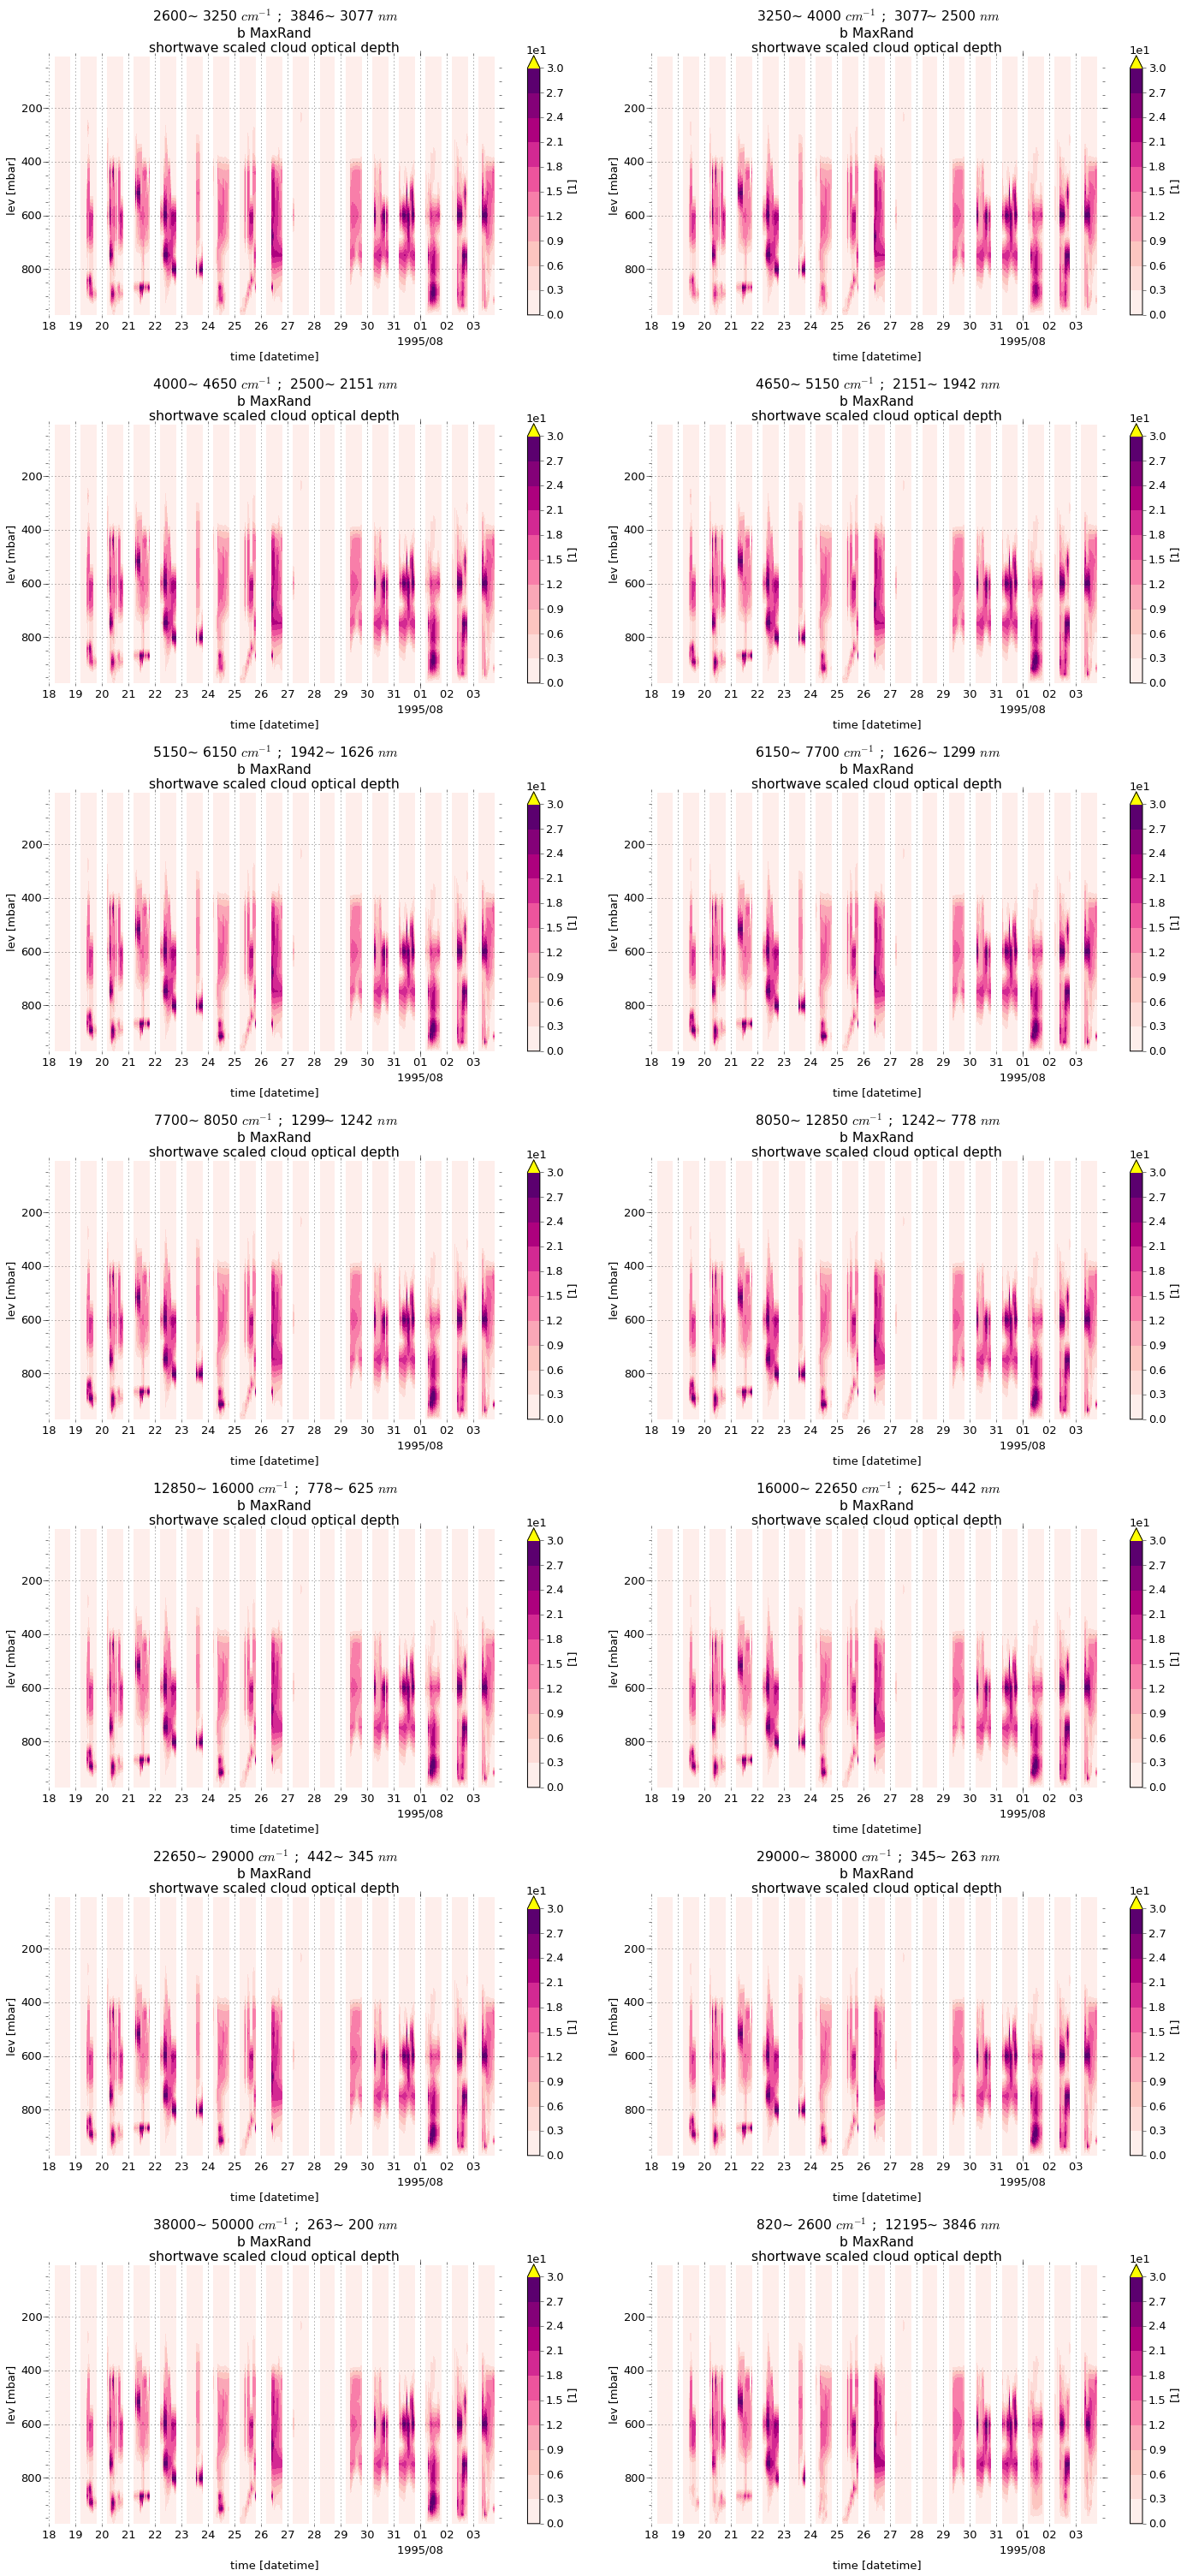

In [318]:
# plot shortwave scaled cloud optical depth
Nwbands = len(rrtmgswinfo.wavenumber_bands().keys())
Nrows = int(np.ceil(Nwbands / 2))

fig, axs = plt.subplots(nrows = Nrows, ncols = 2, figsize = (20, 6 * Nrows))

for wbandn, ax in zip(range(1, Nwbands + 1), axs.flatten()):
    ax = plot_tauc(ax, dsets, spectral_region='shortwave', wbandn = wbandn)    


plt.tight_layout()

In [285]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')